In [1]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys

if sys.version_info < (3, 6):
    raise Exception("Please use Python version 3.6 or greater.")

try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")
import math

# Qiskit packages
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.optimizers import SPSA

In [2]:
# Initialize the problem by defining the parameters
n = 3  # number of nodes + depot (n+1)
K = 1  # number of vehicles
#addresses = ['4949 Stevenson Blvd, Fremont', '6166 Cottle Rd, San Jose', '2217 Market St, San Francisco']
addresses = ['Los Angeles', 'Sacramento', 'Charlotte']
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="VRP Using QC")

In [14]:
# Get the data
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n
        xc = np.zeros([n])
        yc = np.zeros([n])
        for i in range(0, n):
            location = geolocator.geocode(addresses[i])
            xc[i] = location.latitude
            yc[i] = location.longitude
        
        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = math.sqrt((xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2)
                instance[jj, ii] = instance[ii, jj]

        print(instance)
        #np.random.seed(33)
        #np.random.seed(1543)

        #xc = (np.random.rand(n) - 0.5) * 10
        #yc = (np.random.rand(n) - 0.5) * 10

        #instance = np.zeros([n, n])
        #for ii in range(0, n):
            #for jj in range(ii + 1, n):
            #    instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
            #    print(instance[ii, jj])
            #    instance[jj, ii] = instance[ii, jj]
            #    print(instance[jj, ii])

        return xc, yc, instance

In [15]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc, yc, instance = initializer.generate_instance()

[[ 0.          5.57377037 37.41808994]
 [ 5.57377037  0.         40.78893065]
 [37.41808994 40.78893065  0.        ]]


In [5]:
class ClassicalOptimizer:

    def __init__(self, instance,n,K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles


    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n-self.K)


    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0])+[0. for x in range(0,n-1)]
        my_ub = [1 for x in range(0,n**2+n-1)]
        my_lb = [0 for x in range(0,n**2)] + [0.1 for x in range(0,n-1)]
        my_ctype = "".join(['I' for x in range(0,n**2)]) + "".join(['C' for x in range(0,n-1)])

        my_rhs = 2*([K] + [1 for x in range(0,n-1)]) + [1-0.1 for x in range(0,(n-1)**2-(n-1))] + [0 for x in range(0,n)]
        my_sense = "".join(['E' for x in range(0,2*n)]) + "".join(['L' for x in range(0,(n-1)**2-(n-1))])+"".join(['E' for x in range(0,n)])

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x,cost


    def populatebyrow(self,prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj = my_obj, lb = my_lb, ub = my_ub, types = my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0,n):
            col = [x for x in range(0+n*ii,n+n*ii)]
            coef = [1 for x in range(0,n)]
            rows.append([col, coef])

        for ii in range(0,n):
            col = [x for x in range(0+ii,n**2,n)]
            coef = [1 for x in range(0,n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0,n):
                if (ii != jj)and(ii*jj>0):

                    col = [ii+(jj*n), n**2+ii-1, n**2+jj-1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0,n):
            col = [(ii)*(n+1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance,n,K)

# Print number of feasible solutions
print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

Number of feasible solutions = 3.0


In [6]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer


class QuantumOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n
        self.K = K

    def binary_representation(self, x_sol=0):

        instance = self.instance
        n = self.n
        K = self.K

        A = np.max(instance) * 100  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n ** 2)
        w_list = [instance_vec[x] for x in range(n ** 2) if instance_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for ii in range(len(w_list)):
            w[ii] = w_list[ii]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n - 1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n * (n - 1)])
        for ii in range(n):
            count = ii - 1
            for jj in range(n * (n - 1)):

                if jj // (n - 1) == ii:
                    count = ii

                if jj // (n - 1) != ii and jj % (n - 1) == count:
                    v[ii][jj] = 1.0

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A * (np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = (
            w
            - 2 * A * (np.kron(Iv_n_1, Iv_n) + vn.T)
            - 2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)
        )

        # c is the constant offset
        c = 2 * A * (n - 1) + 2 * A * (K ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = (
                lambda x: np.dot(np.around(x), np.dot(Q, np.around(x)))
                + np.dot(g, np.around(x))
                + c
            )
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * (n - 1)):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        qp.objective.num_qubits=12
        return qp

    def solve_problem(self, qp):
        algorithm_globals.random_seed = 10598
        quantum_instance = QuantumInstance(
            BasicAer.get_backend("qasm_simulator"),
            seed_simulator=algorithm_globals.random_seed,
            seed_transpiler=algorithm_globals.random_seed,
        )

        qaoa = QAOA(quantum_instance=quantum_instance)
        optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)
        result = optimizer.solve(qp)
        # compute cost of the obtained result
        _, _, _, level = self.binary_representation(x_sol=result.x)
        return result, level, qaoa

In [7]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x,classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
    # Print the solution
    print(z)
except:
    print("CPLEX may be missing.")

[0.0, 1.0, 1.0, 0.0, 0.0, 1.0]


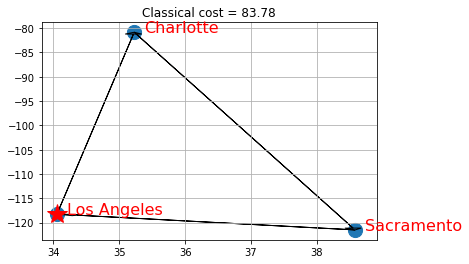

In [8]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(addresses[i], (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()

if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

In [9]:
# Instantiate the quantum optimizer class with parameters:
quantum_optimizer = QuantumOptimizer(instance, n, K)

In [10]:
# Check if the binary representation is correct
try:
    if z is not None:
        Q, g, c, binary_cost = quantum_optimizer.binary_representation(x_sol=z)
        print("Binary cost:", binary_cost, "classical cost:", classical_cost)
        if np.abs(binary_cost - classical_cost) < 0.01:
            print("Binary formulation is correct")
        else:
            print("Error in the binary formulation")
    else:
        print("Could not verify the correctness, due to CPLEX solution being unavailable.")
        Q, g, c, binary_cost = quantum_optimizer.binary_representation()
        print("Binary cost:", binary_cost)
except NameError as e:
    print("Warning: Please run the cells above first.")
    print(e)

Binary cost: 83.7807909669209 classical cost: 83.78079096692454
Binary formulation is correct


In [11]:
qp = quantum_optimizer.construct_problem(Q, g, c)

In [12]:
quantum_solution, quantum_cost, qaoa = quantum_optimizer.solve_problem(qp)
#op, offset = qp.to_ising() 

#ansatz = EfficientSU2(3)
#parameters = list(ansatz.parameters)

#parameters = np.array([0.5, 1.0]) / 2. # divide by 2 to rescale parameters, ends up with same result
#print('qiskit params: ', parameters)
#qc = qaoa.construct_circuit([0,0], op)
#print(qc[0].draw())
print(quantum_solution, quantum_cost)

optimal function value: 83.7807909669209
optimal value: [1. 0. 0. 1. 1. 0.]
status: SUCCESS 83.7807909669209


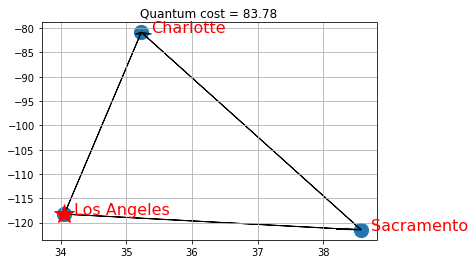

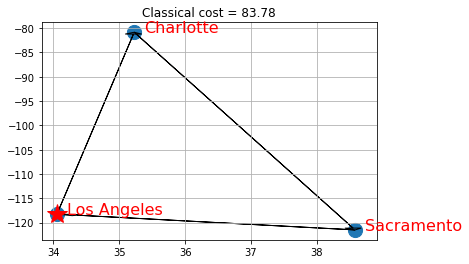

In [13]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution[kk]
        kk +=  1


# visualize the solution
visualize_solution(xc, yc, x_quantum, quantum_cost, n, K, 'Quantum')

# and visualize the classical for comparison
if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')